In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler       # scaling data

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('new.csv',encoding='cp1252',dtype={'id': 'str', 'livingRoom': 'str', 'drawingRoom': 'str','bathRoom': 'str'})
data.head()


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floorfixed
0,https://bj.lianjia.com/chengjiao/101084782030....,1.01E+11,116.475489,40.019520,1.110000e+12,8/9/2016,1464.0,106,415.0,31680,...,2005.0,3,6,0.217,1.0,0.0,1.0,7,56021.0,26
1,https://bj.lianjia.com/chengjiao/101086012217....,1.01E+11,116.453917,39.881534,1.110000e+12,7/28/2016,903.0,126,575.0,43436,...,2004.0,4,6,0.667,1.0,1.0,0.0,7,71539.0,22
2,https://bj.lianjia.com/chengjiao/101086041636....,1.01E+11,116.561978,39.877145,1.110000e+12,12/11/2016,1271.0,48,1030.0,52021,...,2005.0,3,6,0.500,1.0,0.0,0.0,7,48160.0,4
3,https://bj.lianjia.com/chengjiao/101086406841....,1.01E+11,116.438010,40.076114,1.110000e+12,9/30/2016,965.0,138,297.5,22202,...,2008.0,1,6,0.273,1.0,0.0,0.0,6,51238.0,21
4,https://bj.lianjia.com/chengjiao/101086920653....,1.01E+11,116.428392,39.886229,1.110000e+12,8/28/2016,927.0,286,392.0,48396,...,1960.0,2,2,0.333,0.0,1.0,1.0,1,62588.0,6


In [3]:
# Cleaning up data

# filter out 'id'
data = data.drop(['url', 'id', 'Lng', 'Lat', 'Cid', 'price', 'communityAverage'], axis=1)


def filter_nulls(data):
    for column in data.columns:
        data = data[data[column].notnull()]
        
    return data
data = filter_nulls(data)
data.head()

,tradeTime,DOM,followers,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,floorfixed
0,8/9/2016,1464.0,106,415.0,131.00,2,1,1,1,1.0,2005.0,3,6,0.217,1.0,0.0,1.0,7,26
1,7/28/2016,903.0,126,575.0,132.38,2,2,1,2,1.0,2004.0,4,6,0.667,1.0,1.0,0.0,7,22
2,12/11/2016,1271.0,48,1030.0,198.00,3,2,1,3,4.0,2005.0,3,6,0.500,1.0,0.0,0.0,7,4
3,9/30/2016,965.0,138,297.5,134.00,3,1,1,1,1.0,2008.0,1,6,0.273,1.0,0.0,0.0,6,21
4,8/28/2016,927.0,286,392.0,81.00,2,1,1,1,4.0,1960.0,2,2,0.333,0.0,1.0,1.0,1,6


In [4]:
# #normalize
# from sklearn import preprocessing
# names = data.columns
# scaled_data = preprocessing.normalize(data)
# scaled_data = pd.DataFrame(scaled_data, columns=names)

In [5]:
# Add two new columns that individually record year and month of that row
month = []
year = []
for date in data['tradeTime']:
    month.append(date.split('/')[0])
    year.append(date[-2:])

data['month'] = month
data['year'] = year
data = data.drop('tradeTime', axis=1)

data['month']=data['month'].astype('int64')
data['year']=data['year'].astype('int64')
data['livingRoom']=data['livingRoom'].astype('int64')
data['drawingRoom']=data['drawingRoom'].astype('int64')
data['bathRoom']=data['bathRoom'].astype('int64')
data['floorfixed']=data['floorfixed'].astype('int64')



In [6]:
data.head()
data.dtypes

DOM                    float64
followers                int64
totalPrice             float64
square                 float64
livingRoom               int64
drawingRoom              int64
kitchen                  int64
bathRoom                 int64
buildingType           float64
constructionTime       float64
renovationCondition      int64
buildingStructure        int64
ladderRatio            float64
elevator               float64
fiveYearsProperty      float64
subway                 float64
district                 int64
floorfixed               int64
month                    int64
year                     int64
dtype: object

In [7]:
# # Handling missing values
# col_name = data.columns
# from sklearn.impute import SimpleImputer
# impu = SimpleImputer()
# data = pd.DataFrame(impu.fit_transform(data))
# data.columns = col_name

# data['month']=data['month'].astype('int64')
# data['year']=data['year'].astype('int64')

In [8]:
# ####### checking variance, for variance selector we need to specify a threshold (e.g. 0.01) to actually remove features
# ####### or use along with select percentile
data.var().sort_values()



kitchen                1.372768e-02
bathRoom               1.820981e-01
fiveYearsProperty      2.376207e-01
subway                 2.405357e-01
elevator               2.443507e-01
drawingRoom            2.587459e-01
livingRoom             5.951698e-01
renovationCondition    1.306420e+00
buildingType           1.587546e+00
year                   1.696978e+00
buildingStructure      3.629942e+00
district               8.083766e+00
month                  1.194277e+01
floorfixed             6.104940e+01
constructionTime       8.100171e+01
square                 1.331267e+03
followers              1.972733e+03
DOM                    2.537191e+03
totalPrice             6.434538e+04
ladderRatio            6.574194e+08
dtype: float64

In [9]:
# #Removing features with low variance
# def variance_threshold_selector(data,threshold):
#     sel = VarianceThreshold(threshold) 
#     sel.fit(data)
#     return data[data.columns[sel.get_support(indices=True)]]


# var_threshold = variance_threshold_selector(data, threshold=8.082569) 


# data.shape

In [10]:
#Univariate feature selection
def univariate_feature_selector(data, k=7):
    uni_select = SelectKBest(chi2, k)
    uni_select.fit_transform(data,data.totalPrice.astype(int))
    return data[data.columns[uni_select.get_support(indices=True)]]

data_uni = univariate_feature_selector(data, k=7) 
data_uni.columns

Index(['DOM', 'followers', 'totalPrice', 'square', 'livingRoom', 'ladderRatio',
       'floorfixed'],
      dtype='object')

In [19]:
# Split data in two cities into test and training data with a test size of 30% (.3)
from sklearn.model_selection import train_test_split # typically done at the start
train_features, test_features, train_outcome, test_outcome = train_test_split(
    data_uni.drop('totalPrice', axis=1), # features
    data_uni.totalPrice, # outcome
    random_state = 1,
    test_size=0.3 # percentage of data to use as the test set
)

In [12]:
poly = PolynomialFeatures()
dscoring = 'neg_mean_absolute_error'
folds = KFold(n_splits=10, shuffle=True, random_state=11)

In [13]:
#ridge gridsearch (unsure if poly makes fit better)
rid = Ridge()
ripipe = make_pipeline(poly, rid)

riparams = {
            'polynomialfeatures__degree':range(1, 5),
            'ridge__alpha': [.001, 0.1, 1.0]
}
rigrid = GridSearchCV(ripipe, riparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
rigrid.fit(train_features, train_outcome)
rigrid.score(test_features, test_outcome)

-141.51332913349918

In [14]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor    # regressor

scaler = MinMaxScaler()
knn = KNeighborsRegressor()
# Create a grid search estimator 
param_grid_knn={'kneighborsregressor__n_neighbors': range(1, 5),
            'kneighborsregressor__weights':['uniform', 'distance']}
pipeline_knn = make_pipeline(scaler, knn)
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, cv=10, scoring="neg_mean_absolute_error") 
grid_knn.fit(train_features, train_outcome)
grid_knn.score(test_features, test_outcome)


-128.19151228154595

In [15]:
# AdaBoostRegressor
# this model take a long time to run
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
# Create a grid search estimator 
param_grid_ada={'n_estimators': range (1, 5),
            'learning_rate': np.arange(10, 15, 0.1),
            'loss': ['linear', 'square', 'exponential']
               }
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_ada = GridSearchCV(ada, param_grid=param_grid_ada, cv=10, scoring="neg_mean_absolute_error") 
grid_ada.fit(train_features, train_outcome)
grid_ada.score(test_features, test_outcome)

-134.4392917315591

In [28]:
#random forest gridsearch
rfr = RandomForestRegressor()

rfparams = {
            #'polynomialfeatures__degree':range(1, 5),
            'n_estimators': range(1, 5),
            'min_samples_split': range(5, 15),
            'max_depth': [4,6],
            'min_samples_leaf': [3, 5, 9],
            'max_features': [1.0, 0.3, 0.1]       
}
rfgrid = GridSearchCV(rfr, rfparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
rfgrid.fit(train_features, train_outcome)
rfgrid.score(test_features, test_outcome)

-120.02696158202534

In [ ]:
#gradient boosting gridsearch
gbr = GradientBoostingRegressor(n_estimators=1000, loss='huber')

gparams = {
            #'polynomialfeatures__degree':range(1, 5),
            'learning_rate': [0.1, 0.05, 0.02],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9],
            'max_features': [1.0, 0.3, 0.1]
}
ggrid = GridSearchCV(gbr, gparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
ggrid.fit(train_features, train_outcome)
ggrid.score(test_features, test_outcome)

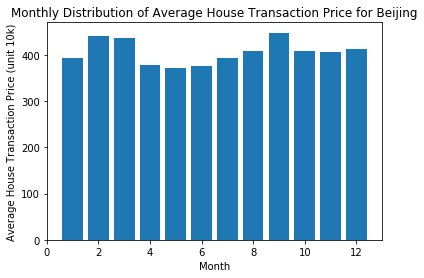

In [35]:
def month(dataset):
    """distribution of the average housing transaction price (unit is 10k) each month
    """
    price_month = dataset.groupby('month').mean()
    plt.bar(price_month.index, price_month.totalPrice)
    plt.xlabel('Month')
    plt.ylabel('Average House Transaction Price (unit 10k)')
    plt.title('Monthly Distribution of Average House Transaction Price for Beijing' )
    plt.show()
month(data)

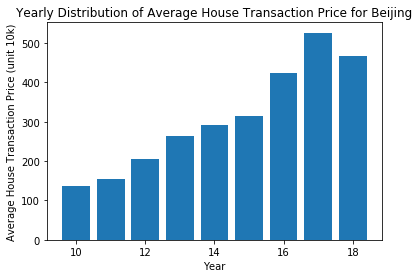

In [36]:
def year(dataset):
    """distribution of the average housing transaction price (unit is 10k) each year
    """
    price_year = dataset.groupby('year').mean()
    plt.bar(price_year.index, price_year.totalPrice)
    plt.xlabel('Year')
    plt.ylabel('Average House Transaction Price (unit 10k)')
    plt.title('Yearly Distribution of Average House Transaction Price for Beijing' )
    plt.show()
year(data)

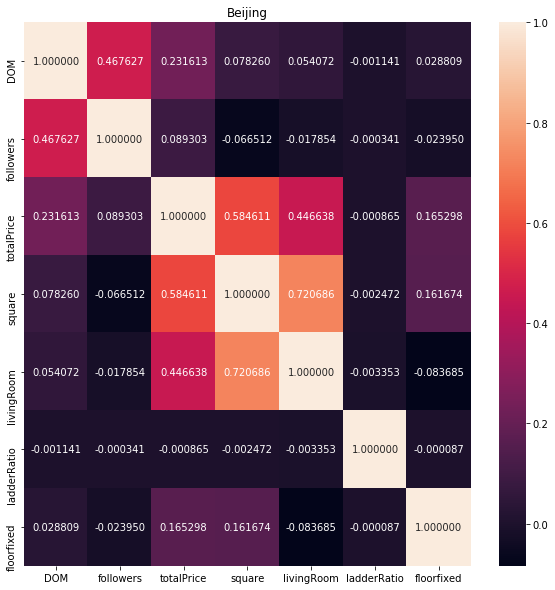

In [37]:
def correlation(dataset):
    """plot each variable selected by univariate selection to find their relationship with totalPrice
    """ 
    plt.figure(figsize = (10, 10))
    sns.heatmap(dataset.corr(), annot=True, fmt='1f')
    plt.title('Beijing')
    plt.show()
correlation(data_uni)